### Notebook for Figure 3 + 4 and relevant data, the SCeptre analysis of the 500ms/'high' dataset.

In [1]:
%matplotlib inline
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import sceptre as spt

## Preparation
Create meta data table and load files into python as "dataset". Alternatively, a meta data table could be created manually and be provided to the function: sceptre.load_dataset()
Mapping is performed with the "File ID" and "Channel" columns.

In [2]:
# create result folder
res_dir = '../results/500ms/'
if not os.path.exists(res_dir):
    os.makedirs(res_dir)

In [3]:
spt.create_meta_data("../data/500ms/", res_dir)

In [4]:
dataset = spt.load_dataset(proteins = "../data/500ms/500ms_Proteins.txt",
                           psms = "../data/500ms/500ms_PSMs.txt",
                           msms = "../data/500ms/500ms_MSMSSpectrumInfo.txt",
                           files = "../data/500ms/500ms_InputFiles.txt",
                           meta = res_dir + "meta.txt")

In [5]:
# mark and remove potential contaminants
contaminants = pd.read_table('../data/contaminants.txt')['Accession']
dataset['proteins']['contaminant'] = dataset['proteins']['Accession'].isin(contaminants)
dataset['proteins'] = dataset['proteins'][dataset['proteins']['contaminant']==False]

## LC-MS QC
Plot various visualizations that inform about the quality of each LC-MS run.

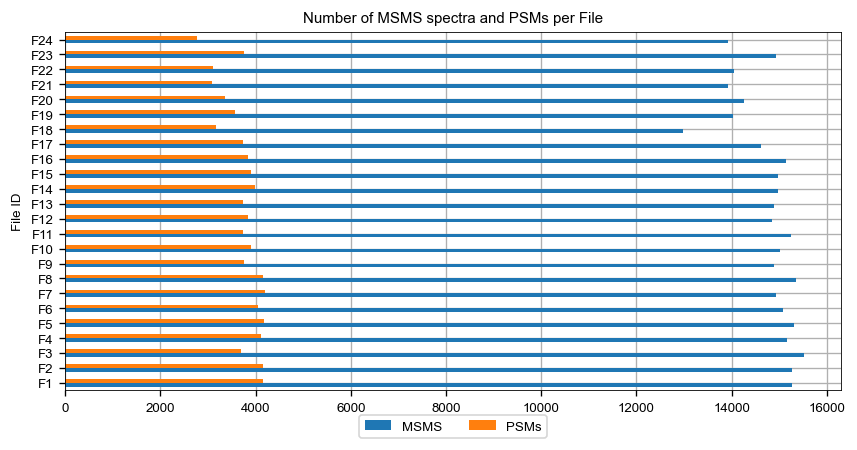

In [6]:
spt.plot_psms_msms(dataset)
plt.savefig(res_dir + "psms_msms.pdf", bbox_inches='tight', transparent=True)

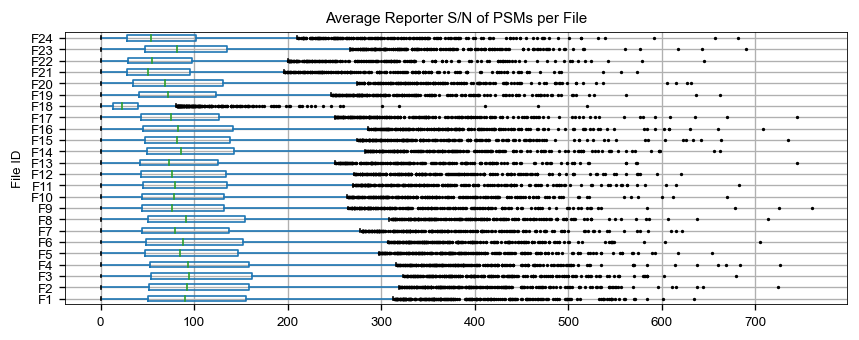

In [7]:
spt.plot_avg_sn(dataset)
plt.savefig(res_dir + "avg_sn.pdf", bbox_inches='tight', transparent=True)

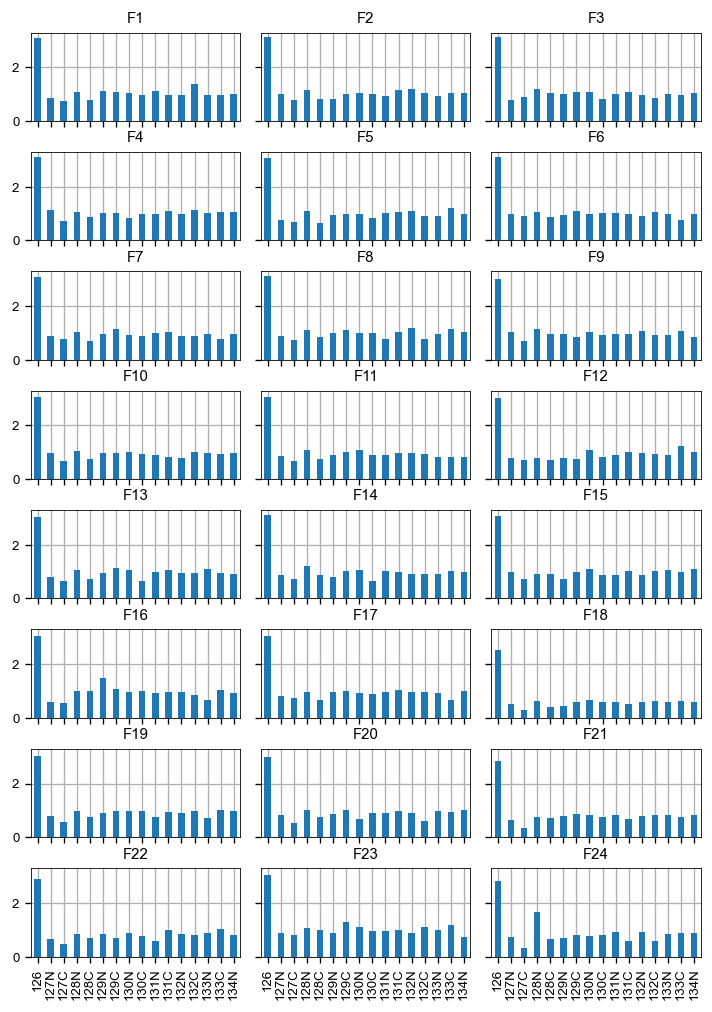

In [8]:
spt.plot_set_overview(dataset)
plt.savefig(res_dir + "set_overview.pdf", bbox_inches='tight', transparent=True)

In [9]:
s_c_channels = ['127N', '128N', '128C', '129N', '129C', '130N', '130C',
                '131N','131C', '132N', '132C', '133N', '133C', '134N']
spt.print_ms_stats(dataset, s_c_channels=s_c_channels)

Protein IDs: 1790
Peptide IDs: 8826
PSMs: 89939
PSM rate: 0.254
Median of median S/N in single-cell channels: 8.75
Median of mean S/N in single-cell channels: 12.647
Median S/N of booster channel: 1075.0
Mean protein IDs per file: 998.75


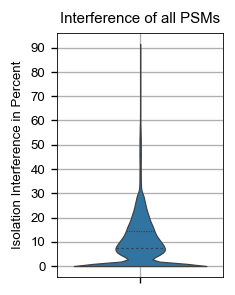

In [10]:
spt.plot_interference(dataset)
plt.savefig(res_dir + "interference.pdf", bbox_inches='tight', transparent=True)

## Load data into Scanpy

In [11]:
adata = spt.dataset_to_scanpy(dataset)

In [12]:
# transform meta columns to categories
adata.obs["Column"] = adata.obs["Column"].astype(pd.Int64Dtype()).astype("category")
adata.obs["Plate"] = adata.obs["Plate"].astype(str).astype("category")
# object columns to category
adata.obs.loc[:, adata.obs.dtypes == "object"] = adata.obs.select_dtypes(["object"]
                                                                          ).apply(lambda x: x.astype("category"))
# order some columns
adata.obs["File ID"] = adata.obs["File ID"].cat.reorder_categories(adata.obs["File ID"].unique(), ordered=True)
adata.obs["Channel"] = adata.obs["Channel"].cat.reorder_categories(adata.obs["Channel"].unique(), ordered=True)

# normalize facs parameter between 0 and 1
fasc_params = ['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'APC-Cy7-A', 'PE-A']
adata.obs[fasc_params] = adata.obs[fasc_params].apply(lambda x: (x-x.min())/(x-x.min()).max())
# rename the facs parameter
adata.obs = adata.obs.rename(columns={'APC-Cy7-A': 'CD34 APC-Cy7-A', 'PE-A': 'CD38 PE-A'})

# set colors for gated and sorted populations
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
adata.uns['Sorted Population_colors'] = [cols[0], cols[1], cols[2]]
adata.uns['Gated Population_colors'] = [cols[3], cols[0], cols[1], cols[2]]

## Filter samples, channels and groups of cells

In [13]:
adata = adata[~adata.obs['Row'].isin(['I', 'J'])].copy() # failed rows on the plate
# remove non-single-cell channels
adata = adata[adata.obs['Channel'] != '126'].copy()
adata = adata[adata.obs['Channel'] != '127C'].copy()

/home/bfurtwa/miniconda3/envs/sceptre_test/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Normalization

In [14]:
spt.normalize(adata)

performed 29 iterations
206 values below 1.1 were set to 0
filtered out 5 genes that are detected in less than 1 cells


## Cell QC

33 of 288 cells do not pass filter


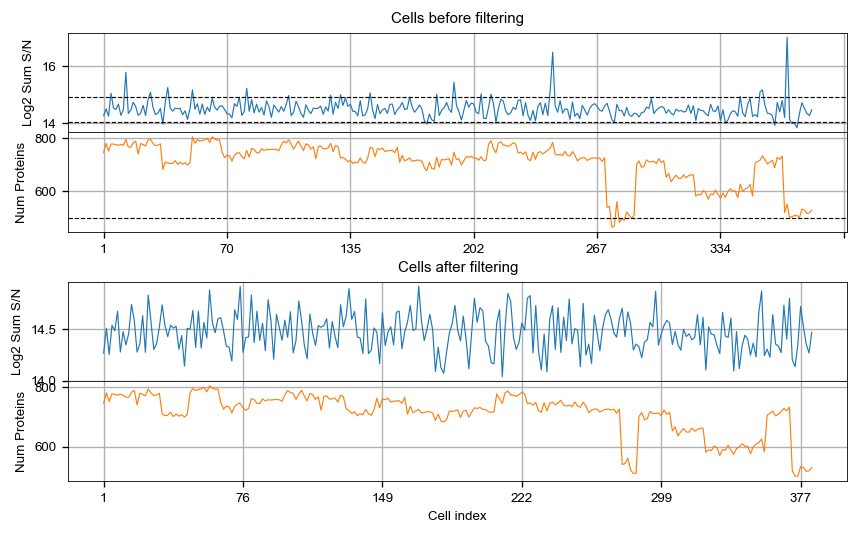

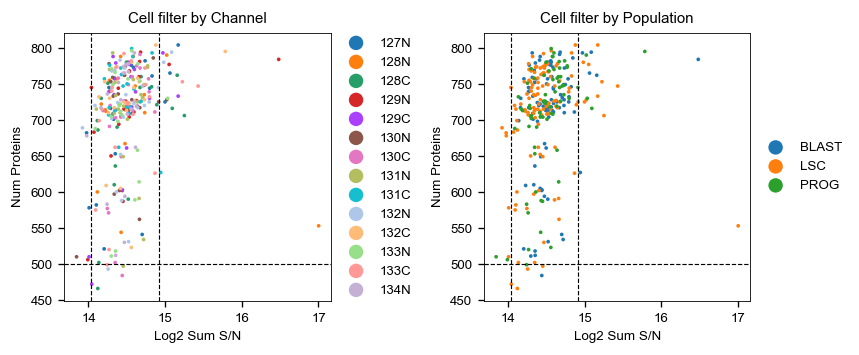

In [15]:
figs = spt.calculate_cell_filter(adata, thresh_sum=2, min_proteins=500)
figs[0].savefig(res_dir + "cell_filter_1.pdf", bbox_inches='tight', transparent=True)
figs[1].savefig(res_dir + "cell_filter_2.pdf", bbox_inches='tight', transparent=True)

In [16]:
spt.apply_cell_filter(adata)

removed 33 cells
filtered out 13 genes that are detected in less than 3 cells


## Batch QC

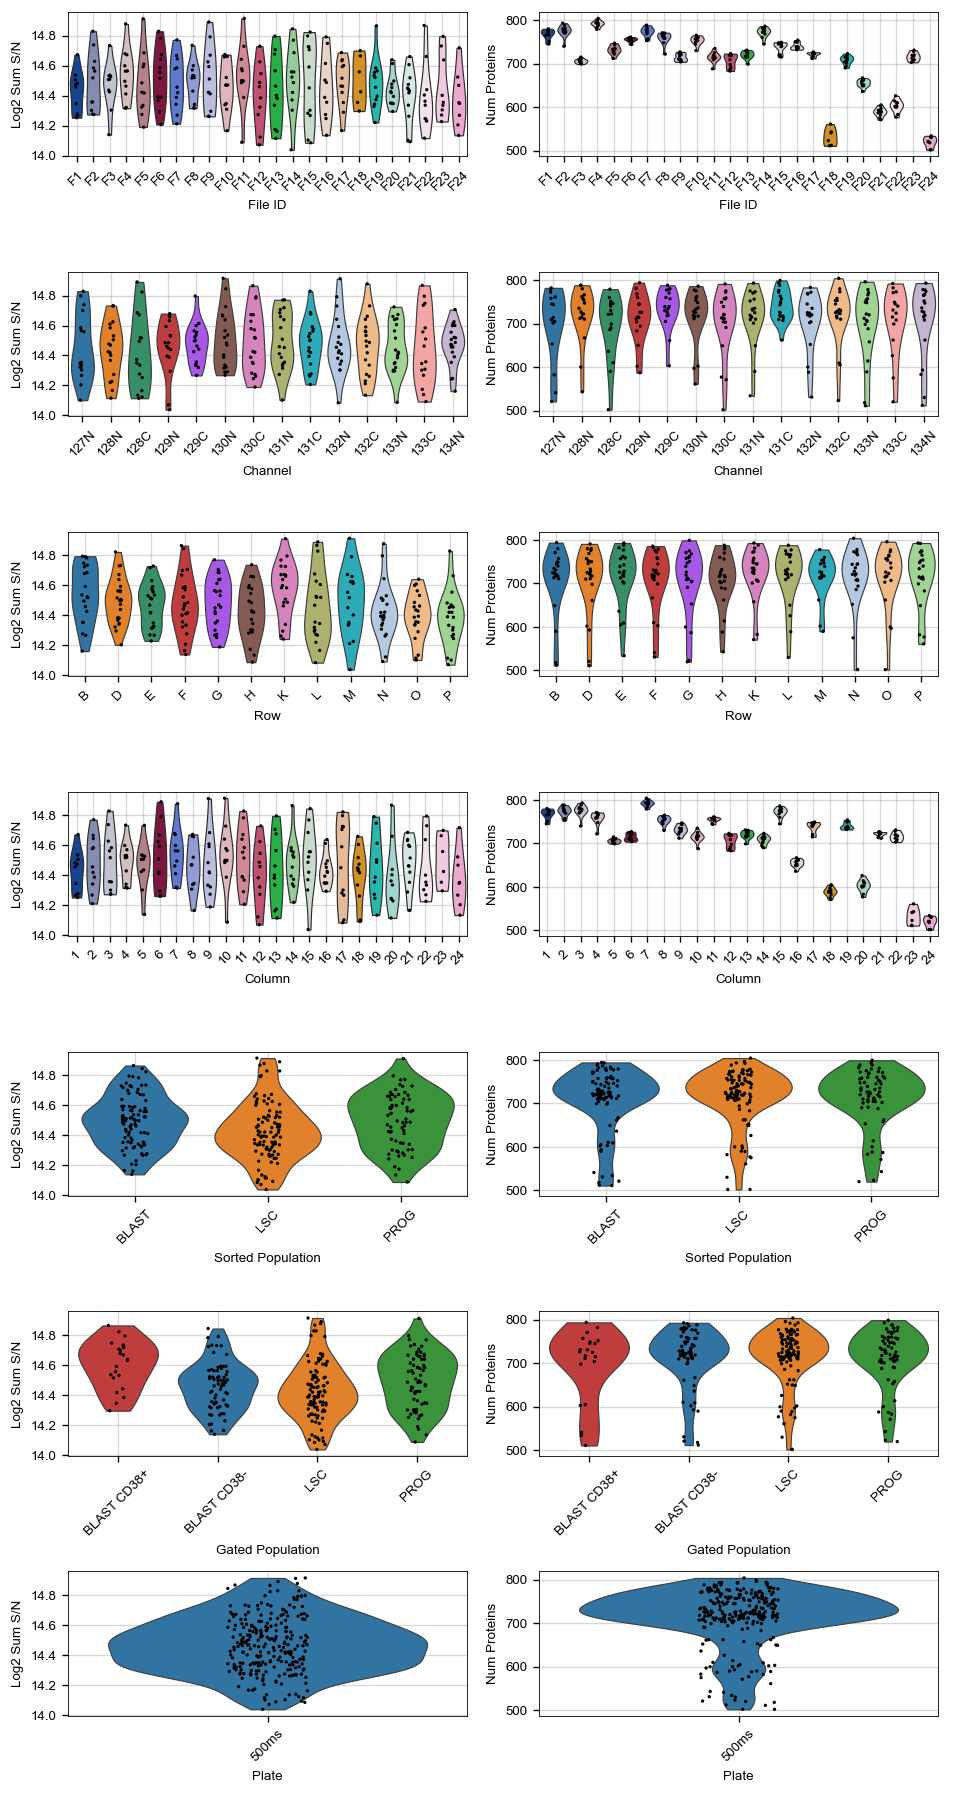

In [17]:
spt.plot_batch_qc(adata)
plt.savefig(res_dir + "batch_qc.pdf", bbox_inches='tight', transparent=True)

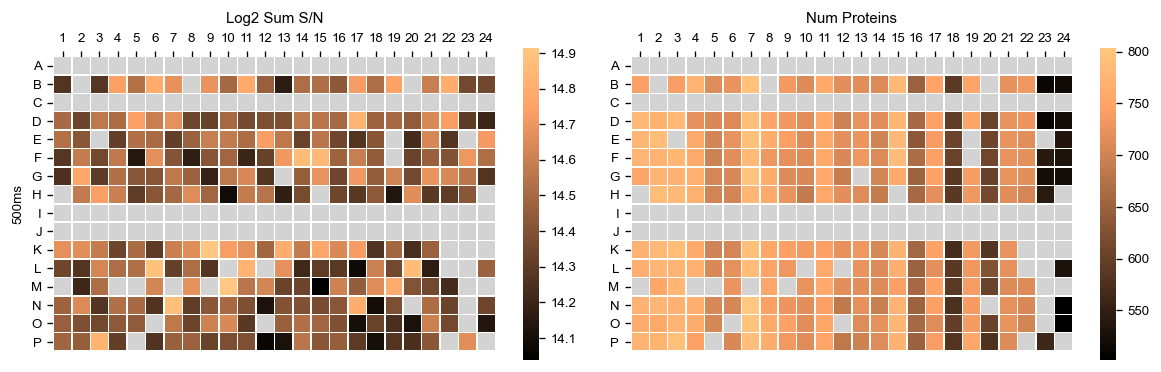

In [18]:
spt.plot_plate_qc(adata)
plt.savefig(res_dir + "plate_qc.pdf", bbox_inches='tight', transparent=True)

mean protein IDs per cell: 712.3
median protein IDs per cell: 725.0
percent missing values: 52.45


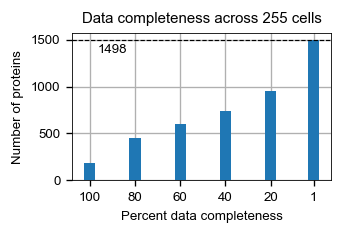

In [19]:
spt.plot_data_completeness(adata)
plt.savefig(res_dir + "data_completeness.pdf", bbox_inches='tight', transparent=True)

/mnt/c/Users/qlj874/OneDrive - Københavns Universitet/Documents/SCeptre/sceptre/sceptre.py:1056: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


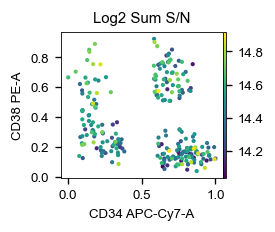

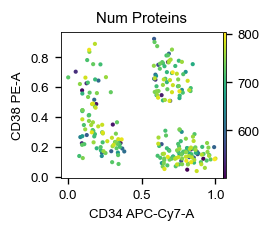

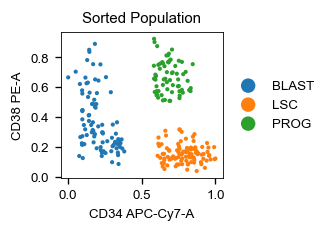

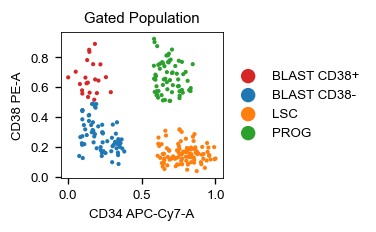

In [20]:
figs = spt.plot_facs_qc(adata, 'CD34 APC-Cy7-A', 'CD38 PE-A')
for i, f in enumerate(figs):
    f.savefig(res_dir + "facs_qc_{}.pdf".format(i), bbox_inches='tight', transparent=True)

## Prepare Embedding

In [21]:
# median shift of total intensity across cells
sc.pp.normalize_total(adata, exclude_highly_expressed=True) 
# log2(x+1) transformation
sc.pp.log1p(adata, base=2)
# save the normalized and log2 transformed data as raw data for differential expression testing
adata.raw = adata

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['S100A8', 'LYZ', 'PRTN3']
    finished (0:00:00)


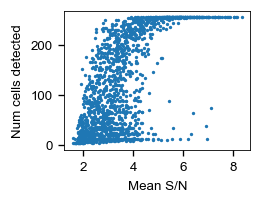

In [22]:
# Missing values vs. mean abundance
df = adata.X.copy()
df[df==0] = np.nan
fig, ax = plt.subplots(figsize=(2, 1.5))
pd.DataFrame({'mean s/n': np.nanmean(df, axis=0),
              'n_cells': adata.var['n_cells']}).plot.scatter(x='mean s/n', y='n_cells', s=1, ax=ax)
ax.set_xlabel('Mean S/N')
ax.set_ylabel('Num cells detected')
fig.savefig(res_dir + 'missing_values_mean_sn.pdf', bbox_inches='tight', transparent=True)

impute_knn: 1/1
	fraction filter: 1/11
	fraction filter: 2/11
	fraction filter: 3/11
	fraction filter: 4/11
	fraction filter: 5/11
	fraction filter: 6/11
	fraction filter: 7/11
	fraction filter: 8/11
	fraction filter: 9/11
	fraction filter: 10/11
	fraction filter: 11/11


impute_knn  Fraction of valid values filter embedding_knn  Silhouette Score
1           5                              0.1            15          0.305494
0           5                              0.0            15          0.303886
2           5                              0.2            15          0.284676
10          5                              1.0            15          0.271589
3           5                              0.3            15          0.270586
8           5                              0.8            15          0.270347
5           5                              0.5            15          0.262551
4           5                              0.4            15          0.255892
6           5                              0.6            15          0.250135
9           5                              0.9            15          0.239463
7           5                              0.7            15          0.234430

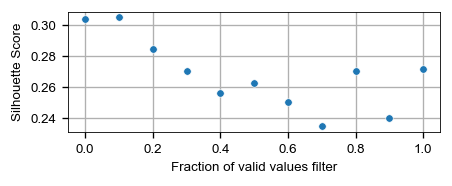

In [23]:
# find the best parameters for the embedding based on celltype separation
# Note that from here on, the code might not be 100% reproducible when changing between computer systems / hardware
# See: https://github.com/theislab/single-cell-tutorial/issues/36#issuecomment-622965632

save_path = '../results/500ms/find_embedding/'
if os.path.exists(save_path):
    shutil.rmtree(save_path)
os.makedirs(save_path)

scores = spt.find_embedding_params(adata, use_rep='umap', save_path=save_path)
plt.savefig(res_dir + "find_embedding_params.pdf", bbox_inches='tight', transparent=True)
scores

In [24]:
# apply fraction of valid values filter
adata = adata[:, (adata.X != 0).sum(axis=0) >= adata.obs.shape[0]*0.1].copy()
spt.impute(adata)
# scale to unit variance and zero mean
sc.pp.scale(adata)
adata

AnnData object with n_obs × n_vars = 255 × 1134
    obs: 'File ID', 'Channel', 'File Name', 'Plate', 'Sample', 'Row', 'Column', 'Well', 'Sorted Population', 'FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'CD34 APC-Cy7-A', 'CD38 PE-A', 'Time', 'Gated Population', 'Num Proteins', 'Log2 Sum S/N', 'Pass Cell Filter'
    var: 'Accession', 'Description', 'Biological Process', 'Cellular Component', 'Molecular Function', 'KEGG Pathways', 'Reactome Pathways', 'WikiPathways', 'n_cells', 'mean', 'std'
    uns: 'Sorted Population_colors', 'Gated Population_colors', 'Channel_colors', 'File ID_colors', 'Row_colors', 'Column_colors', 'Plate_colors', 'log1p'

### Heatmap

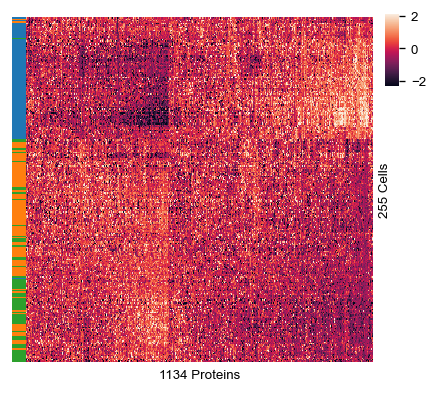

In [25]:
ax = sc.pl.clustermap(adata, obs_keys='Sorted Population', metric='correlation',
                      use_raw=False, robust=True, xticklabels=False, yticklabels=False,
                      show=False, cbar_pos=(0.995, .645, .03, .15), figsize=(4, 4))
p = ax.ax_heatmap.set(xlabel='{} Proteins'.format(adata.shape[1]), ylabel='{} Cells'.format(adata.shape[0]))
ax.ax_row_dendrogram.set_visible(False)
ax.ax_col_dendrogram.set_visible(False)
#plt.savefig(res_dir + "heatmap.pdf", bbox_inches='tight', transparent=True) # takes very long

In [26]:
plot_parameters = ['Sorted Population', 'Gated Population', 'File ID', 'Channel', 'Plate',
                   'Row', 'Column', 'Num Proteins', 'Log2 Sum S/N', 'Time', 'FSC-A', 'FSC-H',
                   'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'CD34 APC-Cy7-A', 'CD38 PE-A']
# set cmaps for plot parameters
plot_cmaps = {'Num Proteins': 'copper', 'Log2 Sum S/N': 'copper', 'Time': 'copper',
             'FSC-A': 'cividis', 'FSC-H': 'cividis', 'FSC-W': 'cividis', 'SSC-A': 'cividis',
             'SSC-H': 'cividis', 'SSC-W': 'cividis', 'CD34 APC-Cy7-A': 'cividis', 'CD38 PE-A': 'cividis'}

# plotting options for panels
figsize = (9, 15.5)
wspace = 1
hspace = 0.7
cellsize= 30 # size to plot cells

## PCA

In [27]:
sc.pp.pca(adata)

computing PCA
    with n_comps=50
    finished (0:00:02)


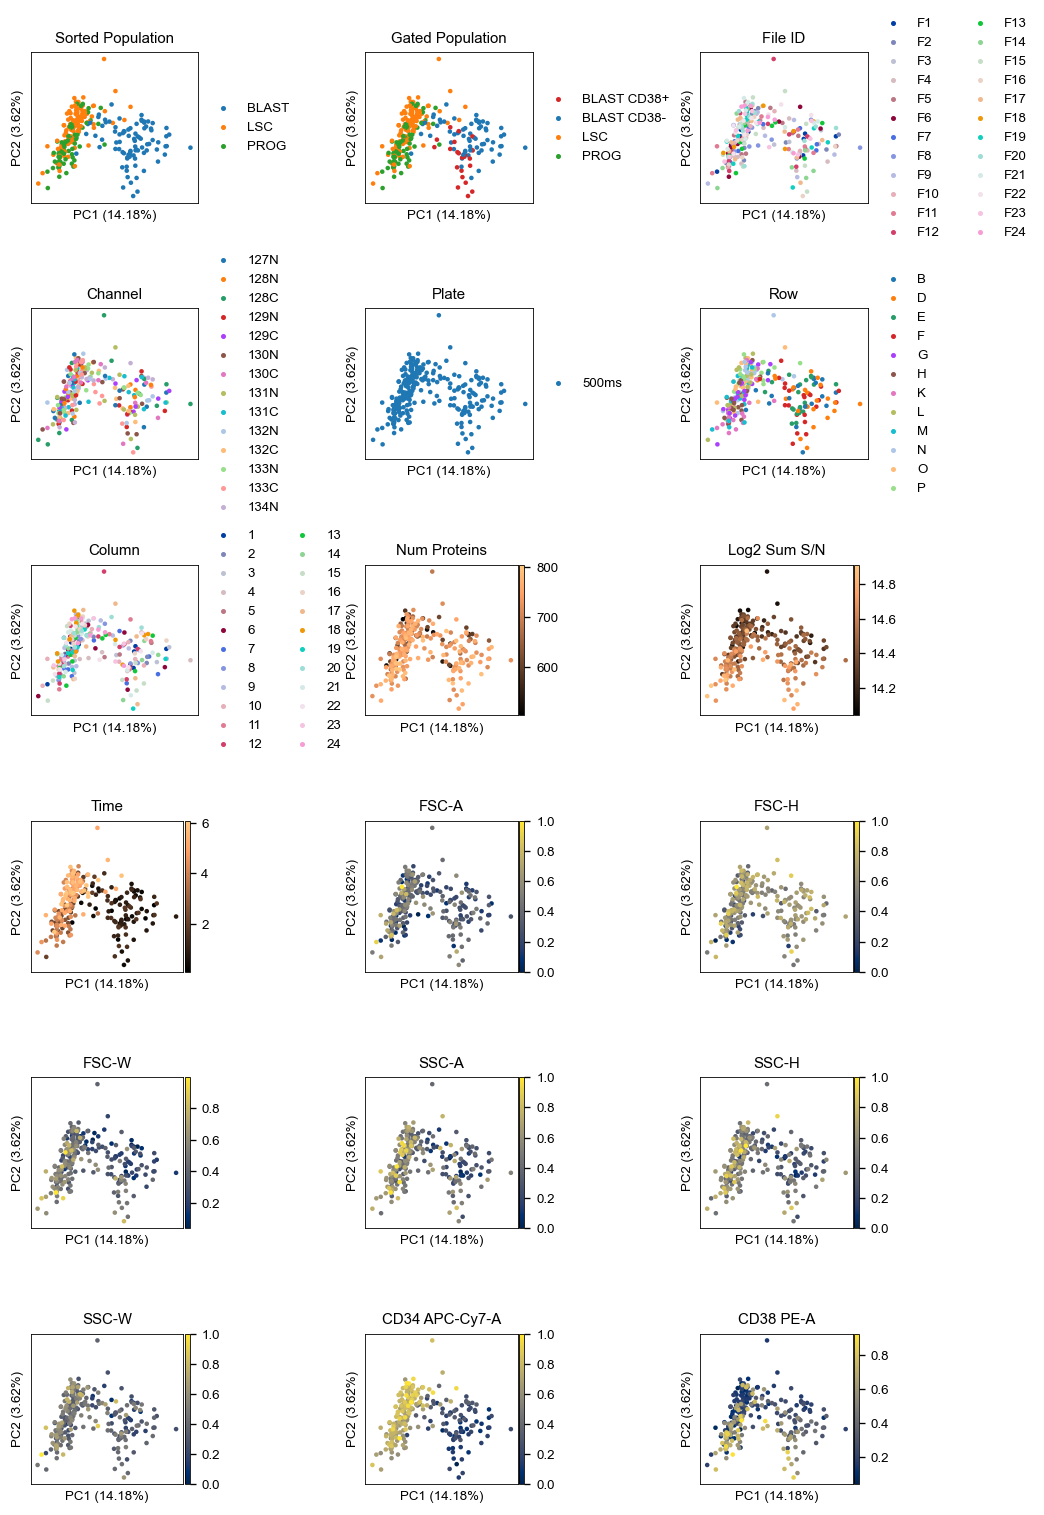

In [28]:
fig = plt.figure(figsize=figsize)
for i, p in enumerate(plot_parameters):
    ax = fig.add_subplot(6, 3, i+1)
    cmap = plot_cmaps[p] if p in plot_cmaps else None
    sc.pl.pca(adata, color=p, size=cellsize, cmap=cmap, show=False, ax=ax, annotate_var_explained=True)
plt.subplots_adjust(wspace=wspace, hspace=hspace)
fig.savefig(res_dir + "pca.pdf", bbox_inches='tight', transparent=True)

## Embedding of the neighborhood graph

In [29]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.draw_graph(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:00)


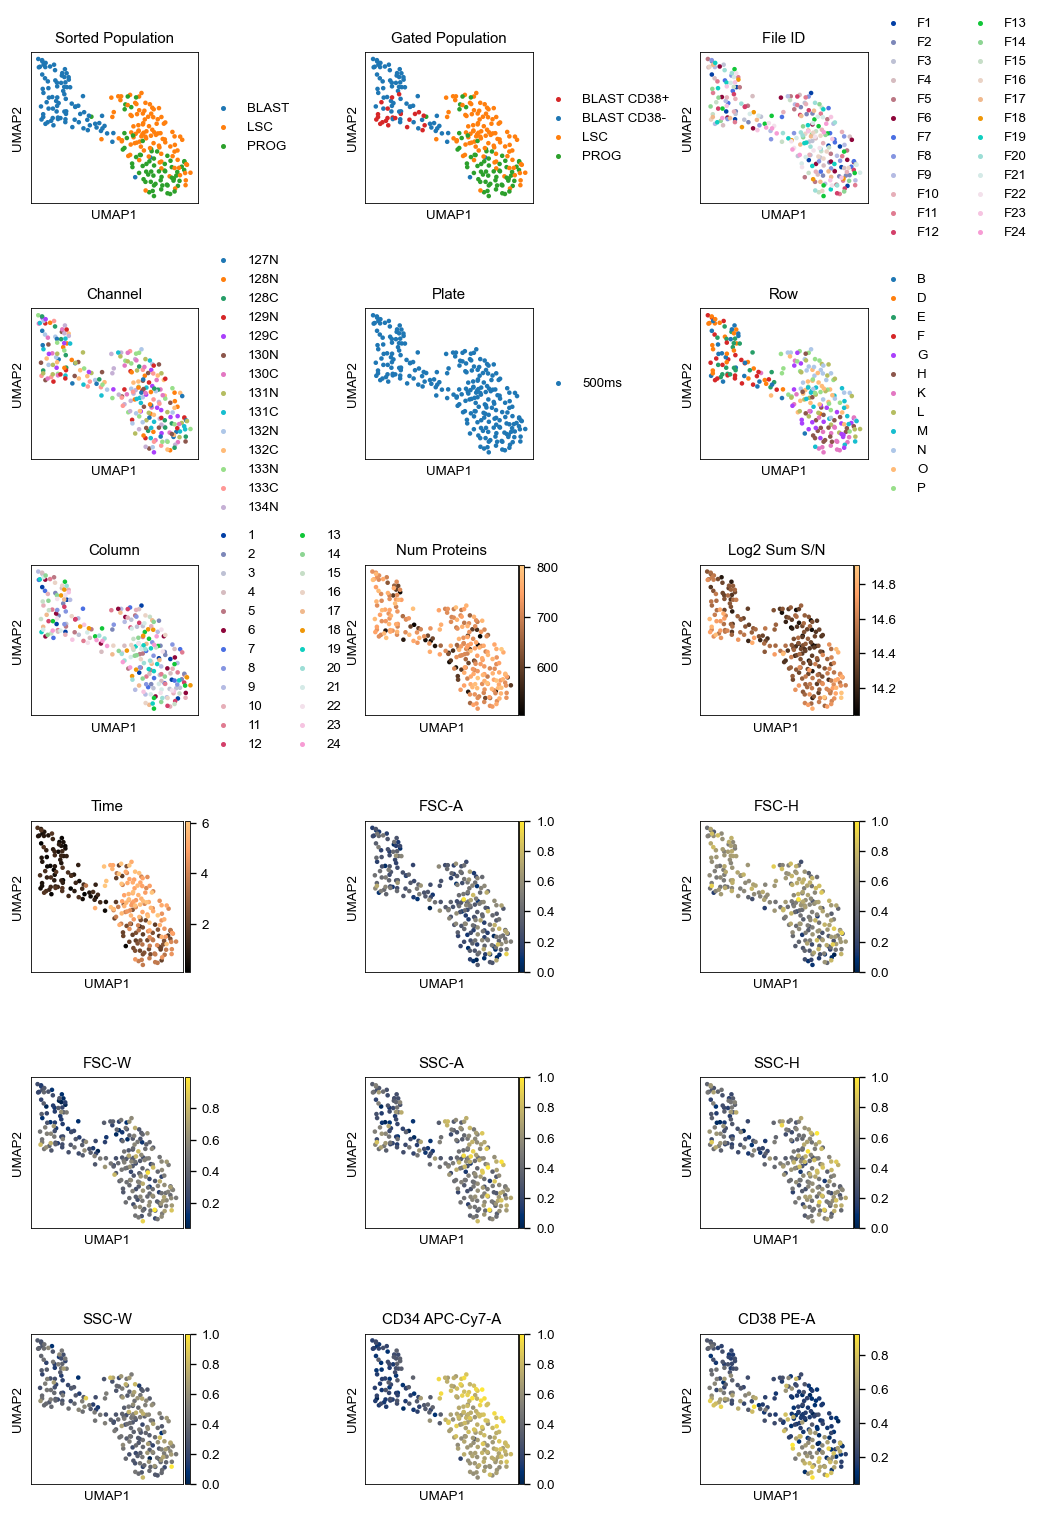

In [30]:
fig = plt.figure(figsize=figsize)
for i, p in enumerate(plot_parameters):
    ax = fig.add_subplot(6, 3, i+1)
    cmap = plot_cmaps[p] if p in plot_cmaps else None
    sc.pl.umap(adata, color=p, size=cellsize, cmap=cmap, show=False, ax=ax)
plt.subplots_adjust(wspace=wspace, hspace=hspace)
fig.savefig(res_dir + "umap.pdf", bbox_inches='tight', transparent=True)

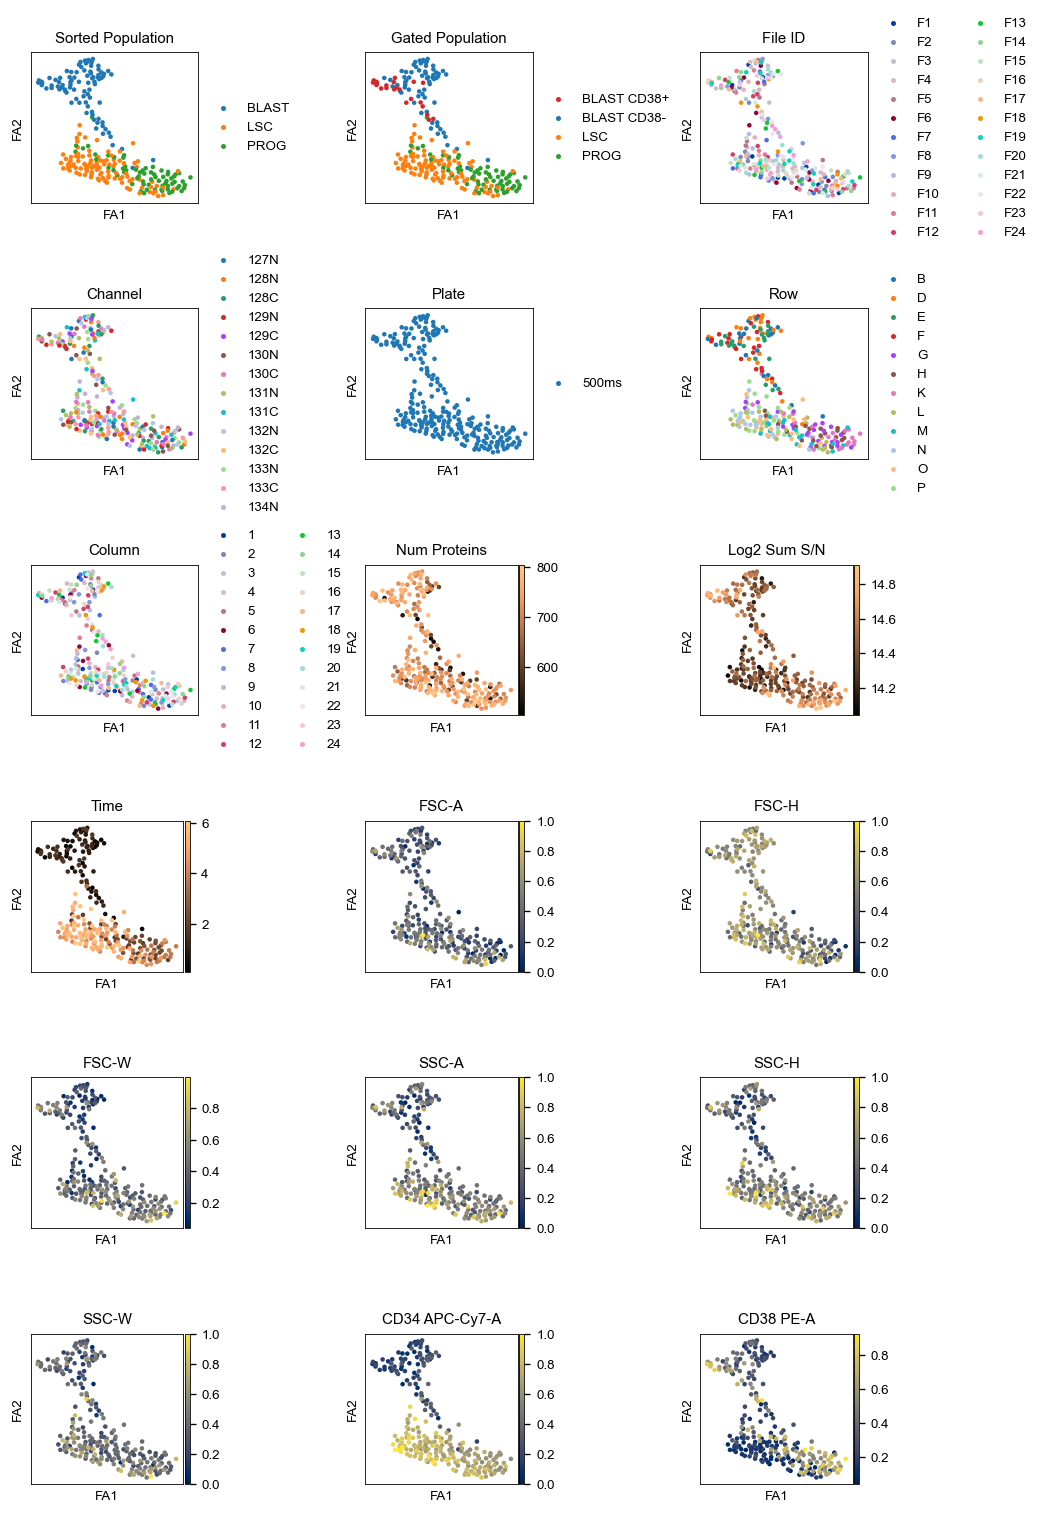

In [31]:
fig = plt.figure(figsize=figsize)
for i, p in enumerate(plot_parameters):
    ax = fig.add_subplot(6, 3, i+1)
    cmap = plot_cmaps[p] if p in plot_cmaps else None
    sc.pl.draw_graph(adata, color=p, size=cellsize, cmap=cmap, show=False, ax=ax)
plt.subplots_adjust(wspace=wspace, hspace=hspace)
fig.savefig(res_dir + "fa.pdf", bbox_inches='tight', transparent=True)

## Test differential expression between sorted populations

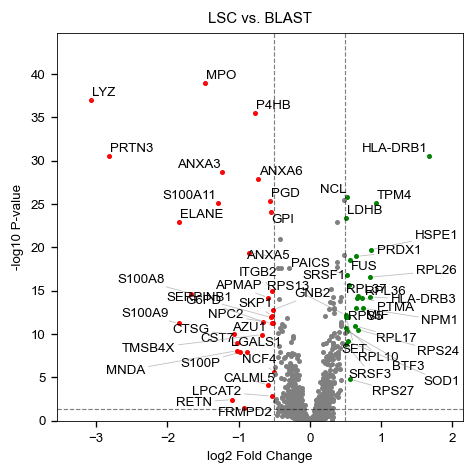

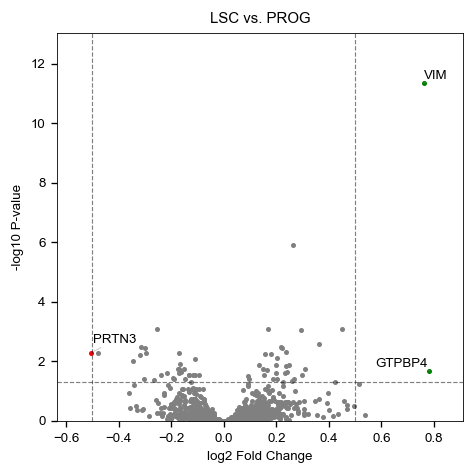

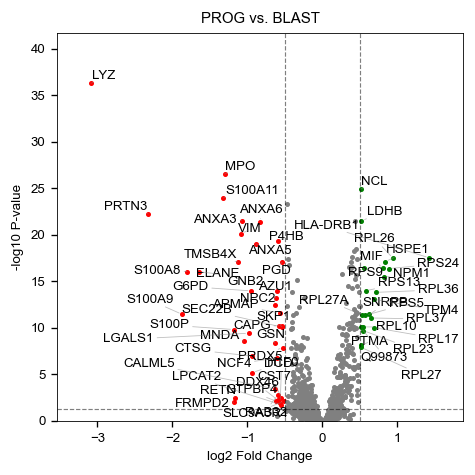

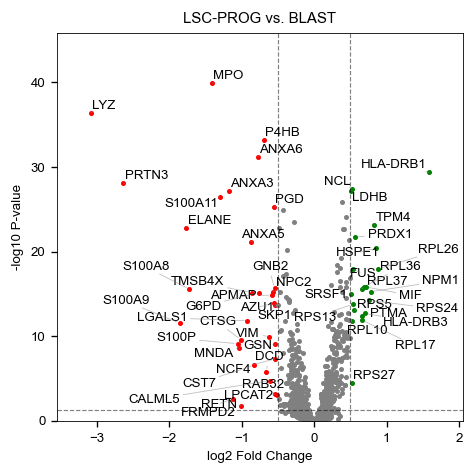

In [32]:
spt.de_test(adata, by='Sorted Population', group1='LSC', group2='BLAST', key='LSC_vs_BLAST')
spt.de_test(adata, by='Sorted Population', group1='LSC', group2='PROG', key='LSC_vs_PROG')
spt.de_test(adata, by='Sorted Population', group1='PROG', group2='BLAST', key='PROG_vs_BLAST')
# create group LSC-PROG vs. BLAST
adata.obs['concat_groups'] = adata.obs['Sorted Population'].apply(
    lambda x: 'BLAST' if x=='BLAST' else 'LSC-PROG').astype('category')

spt.de_test(adata, by='concat_groups', group1='LSC-PROG', group2='BLAST', key='LSC_PROG_vs_BLAST')

spt.plot_volcano(adata, test_key='LSC_vs_BLAST')
plt.savefig(res_dir + "volcano_LSC_vs_BLAST.pdf", bbox_inches='tight', transparent=True)
spt.plot_volcano(adata, test_key='LSC_vs_PROG')
plt.savefig(res_dir + "volcano_LSC_vs_PROG.pdf", bbox_inches='tight', transparent=True)
spt.plot_volcano(adata, test_key='PROG_vs_BLAST')
plt.savefig(res_dir + "volcano_PROG_vs_BLAST.pdf", bbox_inches='tight', transparent=True)
spt.plot_volcano(adata, test_key='LSC_PROG_vs_BLAST')
plt.savefig(res_dir + "volcano_LSC_PROG_vs_BLAST.pdf", bbox_inches='tight', transparent=True)

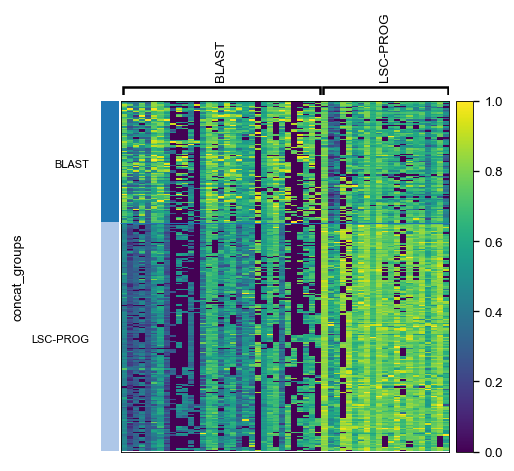

In [33]:
spt.plot_de_heatmap(adata, test_key='LSC_PROG_vs_BLAST')
plt.savefig(res_dir + "heatmap_LSC_PROG_vs_BLAST.pdf", bbox_inches='tight', transparent=True)

In [34]:
# get the de-genes
de_g = adata.uns['LSC_PROG_vs_BLAST']['results']
genes_up = de_g[(de_g['pval_adj'] <= 0.05) & (de_g['log2foldchange'] >= 0.5)]['gene']
genes_down = de_g[(de_g['pval_adj'] <= 0.05) & (de_g['log2foldchange'] <= -0.5)]['gene']

In [35]:
# save de-genes
de_g[(de_g['pval_adj'] <= 0.05) &
     ((de_g['log2foldchange'] >= 0.5) |
      (de_g['log2foldchange'] <= -0.5))].to_csv(res_dir + 'de_prots_LSC_PROG_vs_BLAST.csv', index=False)

In [36]:
# test for enriched terms
spt.enrichment_test(adata, gene_set=genes_up,
                    categories=['Biological Process', 'Cellular Component', 'Molecular Function',
                                'KEGG Pathways', 'Reactome Pathways', 'WikiPathways'], key='LSC-PROG Terms')
spt.enrichment_test(adata, gene_set=genes_down,
                    categories=['Biological Process', 'Cellular Component', 'Molecular Function',
                                'KEGG Pathways', 'Reactome Pathways', 'WikiPathways'], key='BLAST Terms')

In [37]:
adata.uns['LSC-PROG Terms'].to_csv(res_dir + "enriched_terms_lsc_prog.csv")
adata.uns['LSC-PROG Terms']

size background  \
Cytoplasmic Ribosomal Proteins                               1498.0   
Peptide chain elongation                                     1498.0   
 Major pathway of rRNA processing in the nucleo...           1498.0   
 Viral mRNA Translation                                      1498.0   
 Eukaryotic Translation Termination                          1498.0   
 Selenocysteine synthesis                                    1498.0   
 Nonsense Mediated Decay (NMD) independent of t...           1498.0   
 SRP-dependent cotranslational protein targetin...           1498.0   
 Nonsense Mediated Decay (NMD) enhanced by the ...           1498.0   
 Formation of a pool of free 40S subunits                    1498.0   
 L13a-mediated translational silencing of Cerul...           1498.0   
 GTP hydrolysis and joining of the 60S ribosoma...           1498.0   
Ribosome                                                     1498.0   
ribosome                                                     1498.0   
 Regulation of expression of SLITs and ROBOs                 1498.0   
structural molecule activity                                 1498.0   
 Formation of the ternary complex, and subseque...           1498.0   
RNA binding                                                  1498.0   
 Translocation of ZAP-70 to Immunological synapse            1498.0   
 Phosphorylation of CD3 and TCR zeta chains                  1498.0   
PD-1 signaling                                               1498.0   
 Translation initiation complex formation                    1498.0   
 Ribosomal scanning and start codon recognition              1498.0   
 Generation of second messenger molecules                    1498.0   
 Interferon gamma signaling                                  1498.0   
Allograft Rejection                                          1498.0   
Nuclear import of Rev protein                                1498.0   
 TFAP2A acts as a transcriptional repressor dur...           1498.0   

                                                    # in background  \
Cytoplasmic Ribosomal Proteins                                 73.0   
Peptide chain elongation                                       79.0   
 Major pathway of rRNA processing in the nucleo...             78.0   
 Viral mRNA Translation                                        78.0   
 Eukaryotic Translation Termination                            80.0   
 Selenocysteine synthesis                                      78.0   
 Nonsense Mediated Decay (NMD) independent of t...             82.0   
 SRP-dependent cotranslational protein targetin...             87.0   
 Nonsense Mediated Decay (NMD) enhanced by the ...             87.0   
 Formation of a pool of free 40S subunits                      91.0   
 L13a-mediated translational silencing of Cerul...             99.0   
 GTP hydrolysis and joining of the 60S ribosoma...             99.0   
Ribosome                                                       82.0   
ribosome                                                       99.0   
 Regulation of expression of SLITs and ROBOs                  116.0   
structural molecule activity                                  166.0   
 Formation of the ternary complex, and subseque...             32.0   
RNA binding                                                   543.0   
 Translocation of ZAP-70 to Immunological synapse               6.0   
 Phosphorylation of CD3 and TCR zeta chains                     7.0   
PD-1 signaling                                                  7.0   
 Translation initiation complex formation                      54.0   
 Ribosomal scanning and start codon recognition                54.0   
 Generation of second messenger molecules                       9.0   
 Interferon gamma signaling                                    11.0   
Allograft Rejection                                             7.0   
Nuclear import of Rev protein                                   1.0   
 TFA

In [38]:
adata.uns['BLAST Terms'].to_csv(res_dir + "enriched_terms_blast.csv")
adata.uns['BLAST Terms']

size background  \
extracellular                                                1498.0   
Neutrophil degranulation                                     1498.0   
organelle lumen                                              1498.0   
response to stimulus                                         1498.0   
defense response                                             1498.0   
Antimicrobial peptides                                       1498.0   
 Metal sequestration by antimicrobial proteins               1498.0   
 Regulation of Insulin-like Growth Factor (IGF)...           1498.0   
 Regulation of TLR by endogenous ligand                      1498.0   
 Antimicrobial peptides                                      1498.0   
cellular component movement                                  1498.0   
 Caspase-mediated cleavage of cytoskeletal prot...           1498.0   
cellular homeostasis                                         1498.0   
metal ion binding                                            1498.0   

                                                    # in background  \
extracellular                                                 205.0   
Neutrophil degranulation                                       62.0   
organelle lumen                                               252.0   
response to stimulus                                          718.0   
defense response                                               93.0   
Antimicrobial peptides                                          5.0   
 Metal sequestration by antimicrobial proteins                  2.0   
 Regulation of Insulin-like Growth Factor (IGF)...             11.0   
 Regulation of TLR by endogenous ligand                         3.0   
 Antimicrobial peptides                                         3.0   
cellular component movement                                   132.0   
 Caspase-mediated cleavage of cytoskeletal prot...              4.0   
cellular homeostasis                                           96.0   
metal ion binding                                             282.0   

                                                    size subset  # in subset  \
extracellular                                              33.0         21.0   
Neutrophil degranulation                                   33.0         11.0   
organelle lumen                                            33.0         18.0   
response to stimulus                                       33.0         29.0   
defense response                                           33.0         10.0   
Antimicrobial peptides                                     33.0          3.0   
 Metal sequestration by antimicrobial proteins             33.0          2.0   
 Regulation of Insulin-like Growth Factor (IGF)...         33.0          3.0   
 Regulation of TLR by endogenous ligand                    33.0          2.0   
 Antimicrobial peptides                                    33.0          2.0   
cellular component movement                                33.0          8.0   
 Caspase-mediated cleavage of cytoskeletal prot...         33.0          2.0   
cellular homeostasis                                       33.0          6.0   
metal ion binding                                          33.0         13.0   

                                                     expected  enrichment  \
extracellular                                        4.516021    4.650111   
Neutrophil degranulation                             1.365821    8.053763   
organelle lumen                                      5.551402    3.242424   
response to stimulus                                15.817089    1.833460   
defense response                                     2.048732    4.881069   
Antimicrobial peptides                               0.110147   27.236364   
 Metal sequestration by antimicrobial proteins       0.044059   45.393939   
 Regulation of Insulin-like Growth Factor (IGF)...   0.242323   12.380165   
 Regulation of TLR by endo

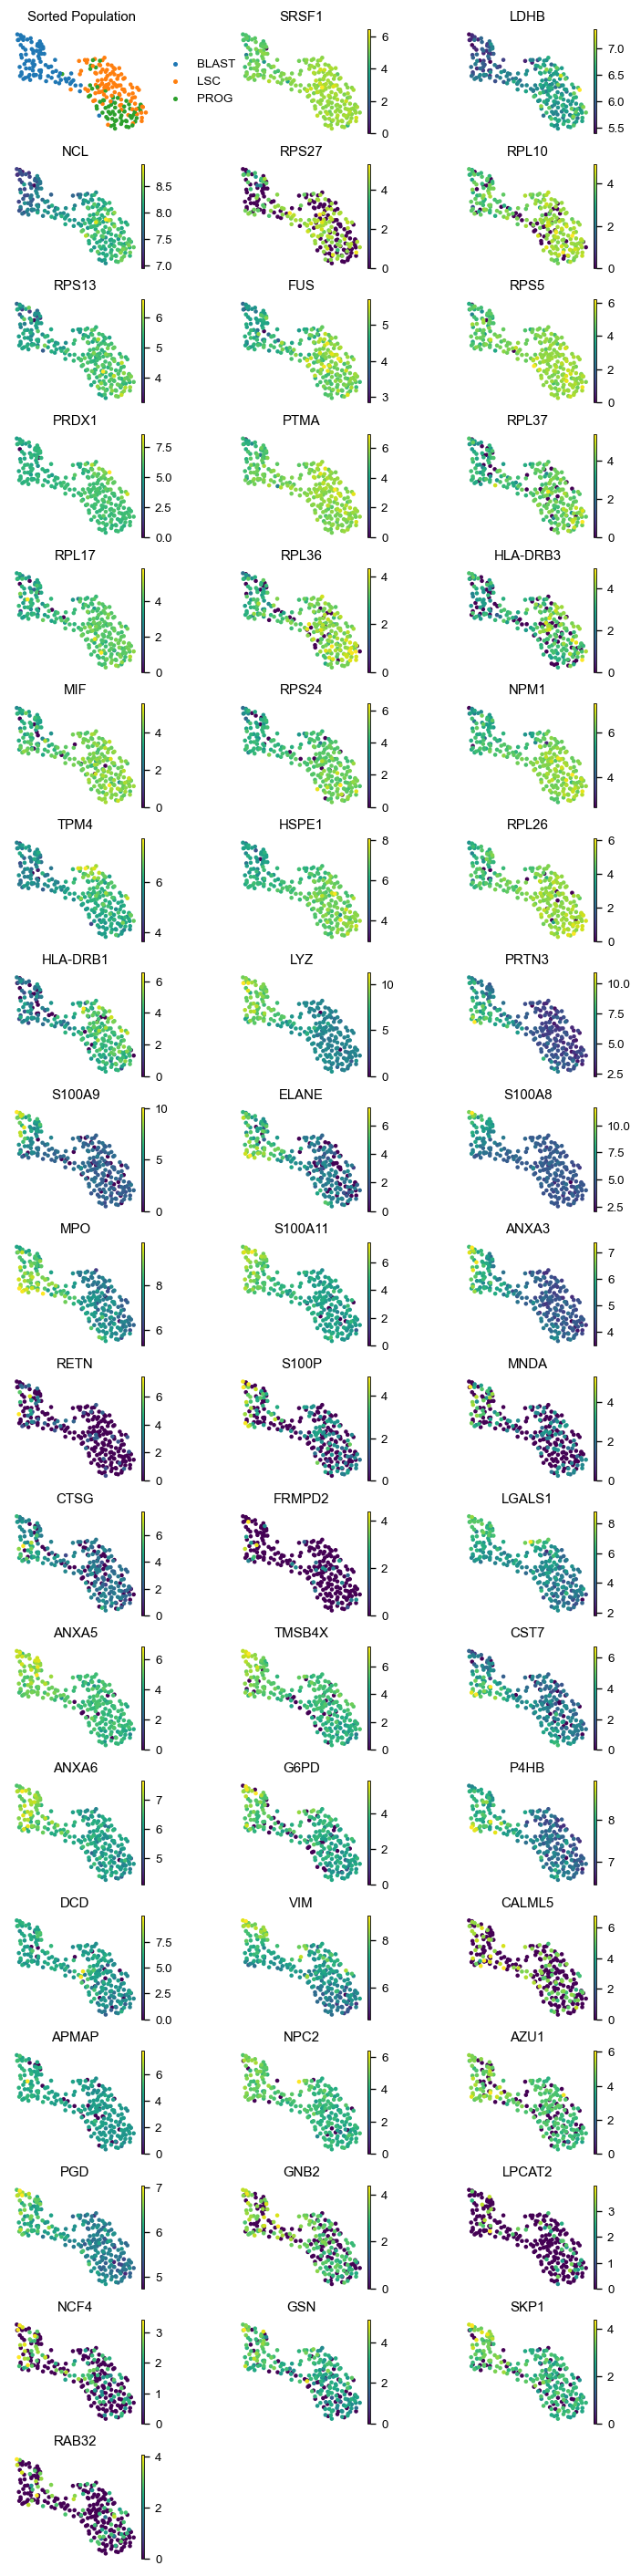

In [39]:
# plot the expression of the de-genes
genes = ['Sorted Population'] + genes_up.append(genes_down).tolist()
n_row = int((len(genes)/3)+1)
fig = plt.figure(figsize=(7, 30))
for i, p in enumerate(genes):
    ax = fig.add_subplot(n_row, 3, i+1)
    sc.pl.umap(adata, color=p, size=cellsize, show=False, ax=ax, frameon=False)
plt.subplots_adjust(wspace=0.6, hspace=0.3)
fig.savefig(res_dir + "marker_LSC_PROG_vs_BLAST.pdf", bbox_inches='tight', transparent=True)

In [40]:
# save adata
adata.write(res_dir + "500ms.h5ad")

In [41]:
os.system('jupyter nbconvert --to html 500ms.ipynb --output-dir={}'.format(res_dir))

0